# AI 201 Programming Assignment 3
## Multi-Layer Perceptron with Backpropagation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
import sys
!{sys.executable} -m pip install --quiet numpy matplotlib imblearn tqdm

In [2]:
import numpy as np
import csv
import time
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm

In [3]:
# Dataset paths
path_to_train_set_features = "data.csv"
path_to_train_set_labels = "data_labels.csv"
path_to_test_set_features = "test_set.csv"

# Training and validation set filenames
filename_train_set_features = "training_set.csv"
filename_train_set_labels = "training_labels.csv"
filename_val_set_features = "validation_set.csv"
filename_val_set_labels = "validation_labels.csv"

# Filename for saving the trained weights
filename_network_weights = "trained_weights.csv"

# Filenames for predictions of Network A and Network B
filename_network_a_pred = "predictions_for_test_tanh.csv"
filename_network_b_pred = "predictions_for_test_leakyrelu.csv"

# MLP training parameters and randomization seed
EPOCHS = 500
DEFAULT_BATCH_SIZE = 8
np.random.seed(0)

## Functions for Reading and Writing CSV Files

In [4]:
# Functions for reading and writing CSV files
def read_csv(path):
    data = []

    with open(path, mode="r") as file:
        csv_reader = csv.reader(file)  
        for row in csv_reader:
            data.append(row)
    return np.array(data, dtype=float)

def write_csv(path, data, mode="w"):
    # Save features to a CSV file
    with open(path, mode=mode, newline="") as file:
        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)

X_imbalanced = read_csv(path_to_train_set_features)
Y_imbalanced = read_csv(path_to_train_set_labels)
# X_test = read_csv(path_to_test_set_features)

In [5]:
# Function for one-hot encoding labels
def one_hot_encoding(x, length):
    encoding = np.zeros(length)
    encoding[int(x)-1] = 1
    return encoding

Y_one_hot_encoded = Y_imbalanced.tolist().copy()
for i in range(len(Y_one_hot_encoded)):
    Y_one_hot_encoded[i] = one_hot_encoding(Y_one_hot_encoded[i][0], 8)
Y_one_hot_encoded = np.array(Y_one_hot_encoded)

## Balancing the Dataset via SMOTE

In [6]:
# Balance out the existing dataset via SMOTE
smote = SMOTE()
X_balanced, Y_balanced = smote.fit_resample(X_imbalanced, Y_one_hot_encoded)

## Splitting the Dataset into Training and Validation Sets

In [7]:
def train_val_split(X, Y, val_size, random_state=None):    
    # Pair each document with its label
    paired = list(zip(X, Y))
    
    # Shuffle the paired documents and labels
    np.random.shuffle(paired)
    
    # Calculate the number of samples in the validation set
    if isinstance(val_size, float):
        val_size = int(len(X)-800)
    
    # Split the paired list into training and validation sets
    train_pairs = paired[:-val_size]
    val_pairs = paired[-val_size:]
    
    # Unzip the pairs back into separate lists
    train_features, train_labels = zip(*train_pairs)
    val_features, val_labels = zip(*val_pairs)
    
    return np.array(train_features), np.array(val_features), np.array(train_labels), np.array(val_labels)

# Retrieve the training, validation, and test sets from the balanced dataset
X_train, X_val, Y_train, Y_val = train_val_split(X_balanced, Y_balanced, val_size=800, random_state=0)
X_test, Y_test = X_imbalanced, Y_imbalanced

print(X_balanced.shape)
print(Y_balanced.shape)
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(13000, 354)
(13000, 8)
(12200, 354)
(800, 354)
(12200, 8)
(800, 8)


In [8]:
# Save the training and validation sets as CSV files
write_csv(filename_train_set_features, X_train)
write_csv(filename_train_set_labels, Y_train)
write_csv(filename_val_set_features, X_val)
write_csv(filename_val_set_labels, Y_val)

## Metrics Calculation Functions

In [9]:
# Functions for calculating the model metrics
def probabilities_to_class_labels(Y_probs):
    return np.argmax(Y_probs, axis=1) + 1

def count_misclassifications(Y_true, Y_pred):
    misclassifications = 0
    for i in range(Y_true.shape[0]):
        if Y_true[i] != Y_pred[i]:
            misclassifications += 1
    
    return misclassifications

def confusion_matrix(Y_true, Y_pred):
    K = len(np.unique(Y_true))  # Number of classes
    result = np.zeros((K, K))

    for i in range(len(Y_true)):
        # Directly use Y_true[i] and Y_pred[i] as indices
        result[Y_true[i] - 1, Y_pred[i] - 1] += 1

    return result

def calculate_model_metrics(Y_true, Y_pred):
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    
    # Accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    
    # Precision, Recall, and F1-score per class
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Overall Precision, Recall, and F1-score (macro averages)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_scores)
    
    # Matthews Correlation Coefficient (MCC)
    mcc_numerator = np.sum(np.diag(conf_matrix) * np.sum(conf_matrix) - np.sum(conf_matrix, axis=0) * np.sum(conf_matrix, axis=1))
    mcc_denominator = np.sqrt(np.sum(conf_matrix) * np.sum(conf_matrix, axis=0) * np.sum(conf_matrix, axis=1) * np.sum(conf_matrix))
    mcc = mcc_numerator / mcc_denominator
    
    return accuracy, macro_precision, macro_recall, macro_f1_score, mcc

## Activation Functions Implementations

In [10]:
class LogisticFunction:
    
    def __init__(self, a=2.0):
        self.a = a
        
    # Numerically stable version for computing the logistic function
    # Uses two versions of the expression depending on the element-wise
    # value of x
    def forward(self, x):
        # Mask for determining which expression to use for logistic function
        pos_mask = (x >= 0)
        z = np.where(pos_mask, np.exp(-self.a * x), np.exp(self.a * x))
        sigma = np.where(pos_mask, 1 / (1 + z), z / (1 + z))
        return sigma
    
    def backward(self, x):
        sigma = self.forward(x)
        return self.a * sigma * (1 - sigma)
    
class Tanh:
    
    def __init__(self, a=1.716, b=2/3):
        self.a = a
        self.b = b
        
    def forward(self, x):
        return self.a * np.tanh(x * self.b)

    def backward(self, x):
        return self.a*self.b * (1/np.cosh(self.b*x))**2
    
class LeakyReLU:
    
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    
    def forward(self, x):
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, x):
        return np.where(x > 0, 1, self.alpha)

## Multi-Layer Perceptron Implementation

In [11]:
class MultiLayerPerceptron:
    
    def __init__(self, input_size, hidden_sizes, output_size, 
                activation_functions=["tanh", "tanh", "logistic"], 
                learning_rate=0.01,
                momentum=0.9, 
                seed=0):
        
        # Network architecture parameters
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_functions = activation_functions

        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.depth = len(self.layer_sizes)
        # print(f"layer_sizes = {self.layer_sizes}")

        # Backpropagation parameters
        self.learning_rate = learning_rate
        self.momentum = momentum

        # Learnable parameters
        self.weights = self.initialize_weights()
        self.best_weights = []
        self.velocity = self.initialize_velocity()

        # np.random.seed(seed)

    def initialize_weights(self):
        weights = []

        # Embed the biasing term in the weights
        for i in range(self.depth - 1):
            w = np.random.randn(self.layer_sizes[i] + 1, self.layer_sizes[i+1]) * np.sqrt(2.0/(self.layer_sizes[i]))
            weights.append(w)
            # print(w.shape)
        return weights

    def initialize_velocity(self):
        velocity = []
        for i in range(self.depth - 1):
            velocity_layer = {
                "weights": np.zeros_like(self.weights[i]),
            }
            velocity.append(velocity_layer)
        return velocity
    
    def save_best_weights(self, filename="trained_weights.csv"):
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            for weight_matrix in self.best_weights:
                # Flatten the weight matrix and convert to list
                flattened_weights = weight_matrix.flatten().tolist()
                # Write the flattened weight matrix to a CSV file
                writer.writerow(flattened_weights)

    def load_weights(self, filename="trained_weights.csv"):
        with open(filename, 'r', newline='') as file:
            reader = csv.reader(file)
            loaded_weights = []
            for i, row in enumerate(reader):
                # Convert row to floats and reshape according to the weight matrix's expected shape
                weight_matrix = np.array(list(map(float, row))).reshape(self.weights[i].shape)
                loaded_weights.append(weight_matrix)
            self.weights = loaded_weights
        
    def sum_squared_errors(self, Y_true, Y_pred):
        E = 1/2 * np.sum((Y_true - Y_pred)**2)
        return E
    
    def forward(self, x):
        self.layers = [x]

        # Forward pass from input layer to hidden layers
        # print(f"{X.shape} x {self.weights[0].shape} x {self.biases[0].shape}")
        for i in range(self.depth - 1):
            bias = np.ones((x.shape[0], 1))
            x = np.concatenate((bias, x), axis=1)
            z = x @ self.weights[i]
            phi = self.activation_functions[i].forward(z)
            self.layers.append(phi)
            x = phi

        return self.layers[-1]
    
    def update_parameters(self):
        # Update weights and biases with momentum
        for i in range(self.depth - 1):
            # Update the velocity for weights and biases
            self.velocity[i]["weights"] = self.momentum * self.velocity[i]["weights"] - self.learning_rate * self.weight_gradients[i]

            # Update the weights and biases using the new velocity
            self.weights[i] += self.velocity[i]["weights"]

    def backpropagation(self, Y_true, Y_pred):
        # Initialize gradients
        self.weight_gradients = []

        # Compute the error
        e = Y_true - Y_pred
        
        # Compute gradients in the output layer
        phi_prime = self.activation_functions[-1].backward(self.layers[-1])
        delta = -e * phi_prime
        weight_gradient = self.layers[-2].T @ delta
        bias_gradient = np.sum(delta, axis=0, keepdims=True)
        self.weight_gradients.append(np.concatenate((bias_gradient, weight_gradient), axis=0))
        
        # Compute gradients in the hidden layers
        for i in range(-2, -self.depth, -1):
            phi_prime = self.activation_functions[i].backward(self.layers[i])
            delta = delta @ self.weights[i+1][1:, :].T * phi_prime
            weight_gradient = self.layers[i-1].T @ delta
            bias_gradient = np.sum(delta, axis=0, keepdims=True)
            self.weight_gradients.append(np.concatenate((bias_gradient, weight_gradient), axis=0))
            
        self.weight_gradients.reverse()
        
        self.update_parameters()

    def generate_mini_batches(self, X, Y, batch_size):
        # Yield mini-batches from the dataset 
        for i in range(0, X.shape[0], batch_size):
            yield X[i:i + batch_size], Y[i:i + batch_size]
        
    def train(self, X_train, Y_train, X_val, Y_val, epochs, batch_size=DEFAULT_BATCH_SIZE):
        # Initialize lists to store training and validation errors
        self.training_errors = []
        self.validation_errors = []
        self.validation_misclassifications = []

        lowest_val_error = float("inf")

        # Record the start time to profile the runtime of the model training
        start_time = time.time()

        # Wrap the range function with tqdm for a progress bar
        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            # Randomly shuffle the training data at the beginning of each epoch
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            Y_train_shuffled = Y_train[indices]

            # Train the model with the training data
            sum_squared_errors_train = 0
            for X_batch, Y_batch in self.generate_mini_batches(X_train_shuffled, Y_train_shuffled, batch_size):
                Y_pred = self.forward(X_batch)
                self.backpropagation(Y_batch, Y_pred)
                sum_squared_errors_train += self.sum_squared_errors(Y_batch, Y_pred)

            # Store the cumulative training error over all batches
            self.training_errors.append(sum_squared_errors_train)

            # Validate the model with the validation data
            Y_pred_val = self.forward(X_val)
            # Note: Typically, backpropagation is not performed on the validation set
            sum_squared_errors_val = self.sum_squared_errors(Y_val, Y_pred_val)
            
            # Calculate and store the validation error and number of 
            # misclassifications every 5 epochs
            if (epoch % 5 == 0):
                misclassification = count_misclassifications(probabilities_to_class_labels(Y_val), probabilities_to_class_labels(Y_pred_val))
                self.validation_errors.append(sum_squared_errors_val)
                self.validation_misclassifications.append(misclassification)
            
                tqdm.write(f"Epoch {epoch} | Validation Sum of Squared Errors: {sum_squared_errors_val}")

            if sum_squared_errors_val < lowest_val_error:
                lowest_val_error = sum_squared_errors_val
                self.best_weights = [np.copy(w) for w in self.weights]  # Deep copy of weights

        end_time = time.time()
        print(f"Model training took {end_time - start_time} seconds")

## Network A

Activation Functions
1. Hyperbolic Tangent $\tanh$ (a = 1.716, b = 2/3)
2. Hyperbolic Tangent $\tanh$ (a = 1.716, b = 2/3)
3. Logistic Function (a = 2)

In [12]:
# Initialize the MLP with tanh as the squashing function
# for the hidden layers, default parameters
input_size, output_size = X_train.shape[1], Y_train.shape[1]
hidden_layer_sizes = [100, 100]
activation_functions = [Tanh(), 
                        Tanh(), 
                        LogisticFunction()
                        ]
                        

# Train the MLP with the training and validation sets
mlp_a = MultiLayerPerceptron(input_size=input_size, 
                             hidden_sizes=hidden_layer_sizes, 
                             output_size=output_size, 
                             activation_functions=activation_functions,
                             learning_rate=0.005)
mlp_a.train(X_train, Y_train, X_val, Y_val, EPOCHS)

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Validation Sum of Squared Errors: 79.24844836387072
Epoch 5 | Validation Sum of Squared Errors: 65.39186555951474
Epoch 10 | Validation Sum of Squared Errors: 18.252268248063395
Epoch 15 | Validation Sum of Squared Errors: 15.058063347941921
Epoch 20 | Validation Sum of Squared Errors: 15.384162307491277
Epoch 25 | Validation Sum of Squared Errors: 9.725598786267952
Epoch 30 | Validation Sum of Squared Errors: 13.007099397651634
Epoch 35 | Validation Sum of Squared Errors: 5.553151517131312
Epoch 40 | Validation Sum of Squared Errors: 27.492272287343734
Epoch 45 | Validation Sum of Squared Errors: 7.149851644279464
Epoch 50 | Validation Sum of Squared Errors: 5.873857759733574
Epoch 55 | Validation Sum of Squared Errors: 4.155006689645433
Epoch 60 | Validation Sum of Squared Errors: 7.272642496467876
Epoch 65 | Validation Sum of Squared Errors: 4.035177946206506
Epoch 70 | Validation Sum of Squared Errors: 6.210846293230807
Epoch 75 | Validation Sum of Squared Errors: 5.17823

In [13]:
# Save the trained weights of Network A for inference and performance evaluation
mlp_a.save_best_weights(filename_network_weights)

In [14]:
Y_test_flattened = Y_test.flatten().astype(np.int64)
mlp_a.load_weights(filename_network_weights)
Y_pred_network_a = mlp_a.forward(X_test)
Y_pred_labels = probabilities_to_class_labels(Y_pred_network_a)

cm = confusion_matrix(Y_test_flattened, Y_pred_labels)
accuracy, macro_precision, macro_recall, macro_f1_score, mcc = calculate_model_metrics(Y_test_flattened, Y_pred_labels)

print(f"MLP Network A Confusion Matrix:\n {cm}")
print(f"MLP Network A Accuracy: {accuracy}")
print(f"MLP Network A Precision: {macro_precision}")
print(f"MLP Network A Recall: {macro_recall}")
print(f"MLP Network A F1-Score: {macro_f1_score}")
print(f"MLP Network A Matthew's Coefficient Correlation: {mcc}")

MLP Network A Confusion Matrix:
 [[1.625e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 2.330e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 3.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 4.830e+02 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.870e+02 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.100e+02 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.200e+01
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 4.000e+00 1.000e+00
  4.600e+02]]
MLP Network A Accuracy: 0.9982788296041308
MLP Network A Precision: 0.9957908882832542
MLP Network A Recall: 0.9983905579399142
MLP Network A F1-Score: 0.9970690407826341
MLP Network A Matthew's Coefficient Correlation: [ 1.55432614 10.84025741 84.1926659   5.22395311  8.8006271   8.09

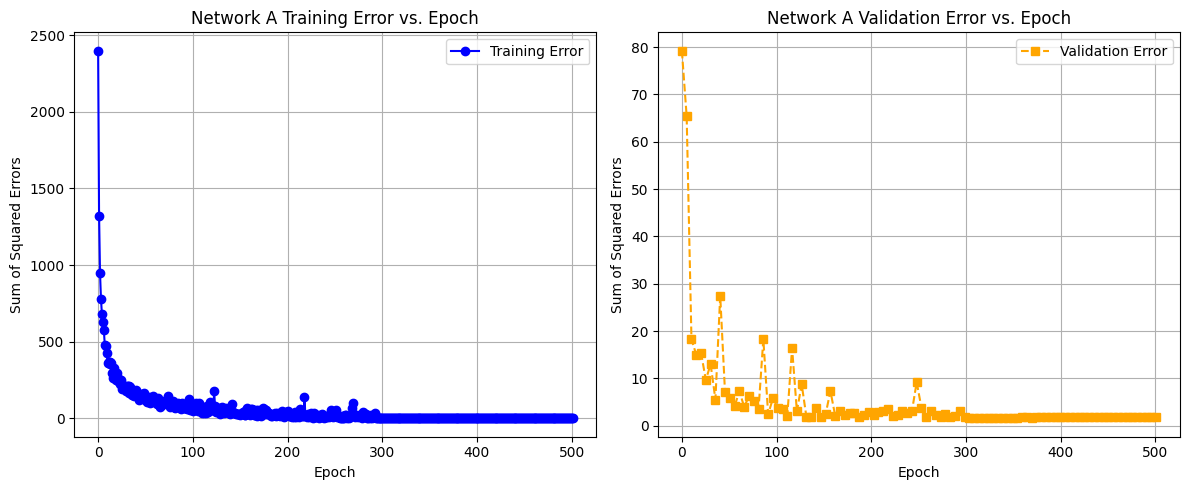

In [15]:
training_epochs = np.linspace(0, EPOCHS + 1, EPOCHS)
validation_epochs = np.linspace(0, EPOCHS + 1, EPOCHS//5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Training Error Plot
axes[0].plot(training_epochs, mlp_a.training_errors, label="Training Error", 
             marker="o", linestyle="-", color='blue')
axes[0].set_title("Network A Training Error vs. Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Sum of Squared Errors")
axes[0].grid(True)
axes[0].legend()

# Validation Error Plot
axes[1].plot(validation_epochs, mlp_a.validation_errors, label="Validation Error", 
             marker="s", linestyle='--', color='orange')
axes[1].set_title("Network A Validation Error vs. Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Sum of Squared Errors")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

## Network B

Activation Functions
1. Leaky ReLU $\tanh$ (alpha = 0.01)
2. Leaky ReLU $\tanh$ (alpha = 0.01)
3. Logistic Function (a = 2)

In [16]:
# Initialize the MLP with the Leaky ReLU as the squashing function
# for the hidden layers
input_size, output_size = X_train.shape[1], Y_train.shape[1]
hidden_layer_sizes = [100, 100]
activation_functions = [LeakyReLU(), 
                        LeakyReLU(), 
                        LogisticFunction()
                        ]

# Train the MLP with the training and validation sets
mlp_b = MultiLayerPerceptron(input_size=input_size, hidden_sizes=hidden_layer_sizes, output_size=output_size, activation_functions=activation_functions)
mlp_b.train(X_train, Y_train, X_val, Y_val, EPOCHS)

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Validation Sum of Squared Errors: 115.80798831355163
Epoch 5 | Validation Sum of Squared Errors: 54.78547469837667
Epoch 10 | Validation Sum of Squared Errors: 25.658814801194552
Epoch 15 | Validation Sum of Squared Errors: 12.95603406674178
Epoch 20 | Validation Sum of Squared Errors: 23.040985644034265
Epoch 25 | Validation Sum of Squared Errors: 11.974838813265057
Epoch 30 | Validation Sum of Squared Errors: 78.73096565632973
Epoch 35 | Validation Sum of Squared Errors: 17.40708781689301
Epoch 40 | Validation Sum of Squared Errors: 5.074938982084175
Epoch 45 | Validation Sum of Squared Errors: 19.908936930001254
Epoch 50 | Validation Sum of Squared Errors: 13.511847984024355
Epoch 55 | Validation Sum of Squared Errors: 6.453790094405541
Epoch 60 | Validation Sum of Squared Errors: 8.40017594967573
Epoch 65 | Validation Sum of Squared Errors: 5.250641686957405
Epoch 70 | Validation Sum of Squared Errors: 7.409105666192181
Epoch 75 | Validation Sum of Squared Errors: 17.8933

C:\Users\lendl\AppData\Local\Temp\ipykernel_10804\2633481340.py:12: RuntimeWarning: overflow encountered in exp
  z = np.where(pos_mask, np.exp(-self.a * x), np.exp(self.a * x))


Epoch 105 | Validation Sum of Squared Errors: 33.68231669054739
Epoch 110 | Validation Sum of Squared Errors: 8.46160130978297
Epoch 115 | Validation Sum of Squared Errors: 3.337963325819267
Epoch 120 | Validation Sum of Squared Errors: 4.340571022743172
Epoch 125 | Validation Sum of Squared Errors: 10.831256123780086
Epoch 130 | Validation Sum of Squared Errors: 2.798499467841356
Epoch 135 | Validation Sum of Squared Errors: 3.2675059078770805
Epoch 140 | Validation Sum of Squared Errors: 8.830122366909318
Epoch 145 | Validation Sum of Squared Errors: 3.7340017110234003
Epoch 150 | Validation Sum of Squared Errors: 2.3813513915093676
Epoch 155 | Validation Sum of Squared Errors: 4.075255524299051
Epoch 160 | Validation Sum of Squared Errors: 3.1543881578717907
Epoch 165 | Validation Sum of Squared Errors: 3.4541453430587454
Epoch 170 | Validation Sum of Squared Errors: 68.92993781422572
Epoch 175 | Validation Sum of Squared Errors: 3.9474044534324726
Epoch 180 | Validation Sum of Squa

In [17]:
# Save the trained weights of Network B for inference and performance evaluation
mlp_b.save_best_weights(filename_network_weights)

In [18]:
Y_test_flattened = Y_test.flatten().astype(np.int64)
mlp_b.load_weights(filename_network_weights)
Y_pred_network_b = mlp_b.forward(X_test)
Y_pred_labels = probabilities_to_class_labels(Y_pred_network_b)

cm = confusion_matrix(Y_test_flattened, Y_pred_labels)
accuracy, macro_precision, macro_recall, macro_f1_score, mcc = calculate_model_metrics(Y_test_flattened, Y_pred_labels)

print(f"MLP Network B Accuracy: {accuracy}")
print(f"MLP Network B Precision: {macro_precision}")
print(f"MLP Network B Recall: {macro_recall}")
print(f"MLP Network B F1-Score: {macro_f1_score}")
print(f"MLP Network B Matthew's Coefficient Correlation: {mcc}")

MLP Network B Accuracy: 0.9965576592082617
MLP Network B Precision: 0.9941978579456148
MLP Network B Recall: 0.9981486602593153
MLP Network B F1-Score: 0.9961549325848946
MLP Network B Matthew's Coefficient Correlation: [ 1.55542579 10.82453665 84.07056799  5.22718838  8.78786425  8.08387455
 48.04250341  5.39493053]


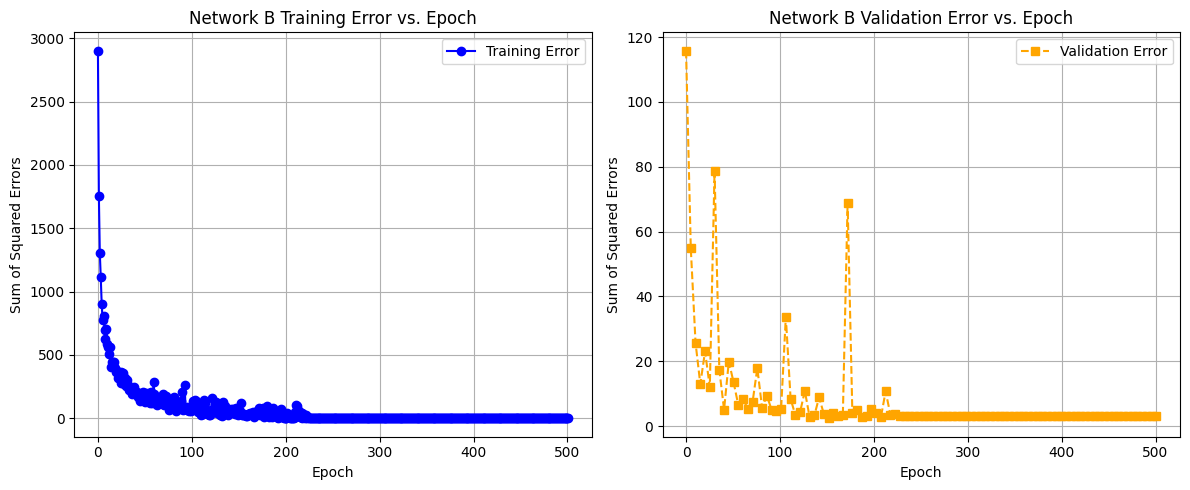

In [19]:
training_epochs = np.linspace(0, EPOCHS + 1, EPOCHS)
validation_epochs = np.linspace(0, EPOCHS + 1, EPOCHS//5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Training Error Plot
axes[0].plot(training_epochs, mlp_b.training_errors, label="Training Error", 
             marker="o", linestyle="-", color='blue')
axes[0].set_title("Network B Training Error vs. Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Sum of Squared Errors")
axes[0].grid(True)
axes[0].legend()

# Validation Error Plot
axes[1].plot(validation_epochs, mlp_b.validation_errors, label="Validation Error", 
             marker="s", linestyle='--', color='orange')
axes[1].set_title("Network B Validation Error vs. Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Sum of Squared Errors")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [20]:
# Save the predictions of Network A
write_csv(filename_network_a_pred, Y_pred_network_a)

# Save the predictions of Network B
write_csv(filename_network_b_pred, Y_pred_network_b)